## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Importing Excel File

In [2]:
df = pd.read_excel('data/Shiller_Ch26_data_modified.xlsx')

In [3]:
print(df.columns)

Index(['Date', 'S&P', 'Dividends', 'Earnings', 'One-Year', 'Long', 'Consumer',
       'Real One-Year Interest Rate', 'Real Per Capita Consumption',
       'Unnamed: 9', 'RealP', 'Present', 'Present.1', 'Present.2', 'RealD',
       'Real Returns S&P', 'Unnamed: 16', 'RealE', 'Price', 'Ten-Year',
       'Price.1'],
      dtype='object')


## Preparing Data

In [4]:
## Creating a dataframe only with interest rates, consumptioin, and stock returns
df = df.loc[:,['Date','Real One-Year Interest Rate','Real Per Capita Consumption','Real Returns S&P']]

In [5]:
df.dropna(inplace=True)

In [6]:
df.head(5)

,Date,Real One-Year Interest Rate,Real Per Capita Consumption,Real Returns S&P
18,1889,1.099140,2731.570142,0.122137
19,1890,1.028390,2674.739801,-0.082419
20,1891,1.128512,2802.827499,0.260760
21,1892,0.964169,2877.010456,-0.015044
22,1893,1.250995,2834.846162,-0.060927


In [7]:
## Obtaining Gross Returns 
df['Gross Returns S&P'] = 1 + df['Real Returns S&P']

In [8]:
## Obtaining Consumption Growth 
df['Consumption Growth'] = df['Real Per Capita Consumption'].pct_change() + 1

In [9]:
df.dropna(inplace=True)

In [10]:
df.head(5)

,Date,Real One-Year Interest Rate,Real Per Capita Consumption,Real Returns S&P,Gross Returns S&P,Consumption Growth
19,1890,1.028390,2674.739801,-0.082419,0.917581,0.979195
20,1891,1.128512,2802.827499,0.260760,1.260760,1.047888
21,1892,0.964169,2877.010456,-0.015044,0.984956,1.026467
22,1893,1.250995,2834.846162,-0.060927,0.939073,0.985344
23,1894,1.078121,2698.707529,0.077294,1.077294,0.951977


## Computing the Hansen-Jagannathan Bound

Let $R_t=\left[R_{t,1},\ldots,R_{t,N}\right]^\prime$ where we have

$R_{t,1}=$ Real One-Year Interest Rate

$R_{t,2}=$ Gross Returns S&P

The Hansen-Jagannathan Bound is calculated through the following calculation:

$\sigma_m=\sqrt{\left(1-\mu_R\mu_m\right)^\prime\Sigma^{-1}\left(1-\mu_R\mu_m\right)}$

where

$ \sigma_{m} $ is the standard deviation of the stochastic discount factor $ m $.

1 is a vector of ones (we measure $E[m]$ as something near “one”, i.e. normalized).

$ \mu_R $ is the vector of expected returns on the set of assets.

$ \mu_m $ is the mean of $ m $.

$ Σ $ is the covariance matrix.

In [11]:
## Obtaining the values for interest rate and gross returns
R = df[['Real One-Year Interest Rate', 'Gross Returns S&P']].values

## Creating a vector of means for interest rate and gross returns
mu_R = R.mean(axis=0) # Calculating the mean of each column (axis=0) from the matrix

## Creating the covariance matrix of returns
Sigma = np.cov(R, rowvar = False) # Variables as columns (rowvar = False)
Sigma_inv = np.linalg.inv(Sigma)

## Obtaining mu_m 
mu_m_values = np.linspace(start=0, stop=2, num=200) # Setting sequence of 200 (range) numbers with equal spacing
sigma_m_values = []

## Storing mu_m
for mu_m in mu_m_values:
    ones = np.ones(mu_R.shape) # Creating an array of ones
    diff = ones - mu_R * mu_m   # Element-wise multiplication
    val = diff @ Sigma_inv @ diff.T # Matrix multiplication (@)
    sigma_m = np.sqrt(val) 
    sigma_m_values.append(sigma_m)

## Computing the Theoritical SDF from CRRA Preferences

The implied SDF under time-additive, CRRA preferences is given by:

$m_{t+1}=\beta\left(\frac{C_{t+1}}{C_t}\right)^{-\gamma}$

where

${\beta}=0.99$ (time discount factor)

${\gamma}=1,2,...,40$ (coefficient of relative risk aversion.)

$(\frac{C_{t+1}}{C_t})=$ Consumption Growth

In [12]:
## Storing the values for consumption growth
consumption_growth = df['Consumption Growth'].values

## Setting input parameters
bet = 0.99
gammas = range(1,41)
crra_means = []
crra_stds = [] 

for g in gammas:
    m_g = bet * (consumption_growth **(-g))
    crra_means.append(m_g.mean())
    crra_stds.append(m_g.std())

## Plotting the theoretical stochastic discount factors along with the Hansen-Jagannathan bound

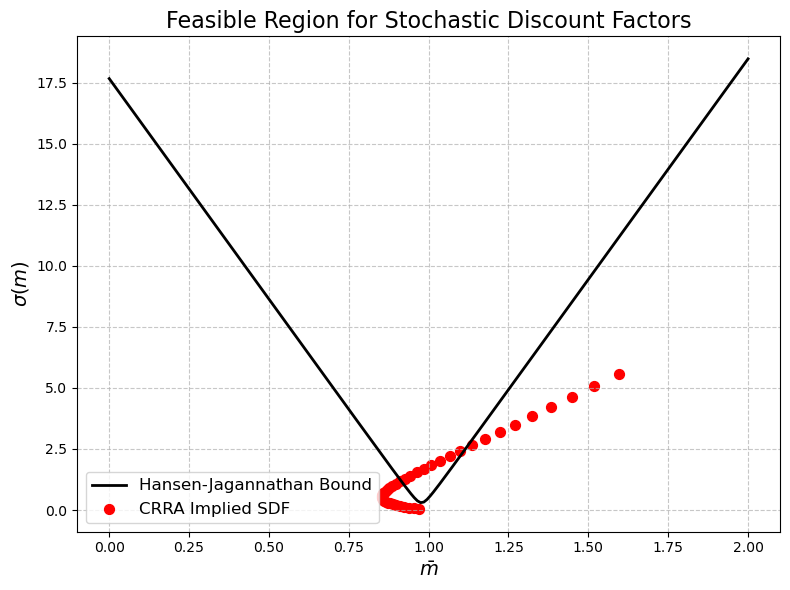

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

## Ploting the HJ bound as a line
ax.plot(mu_m_values, sigma_m_values, color='black', linewidth=2, label='Hansen-Jagannathan Bound')

## Ploting the CRRA-implied SDF points as scatter
ax.scatter(crra_means, crra_stds, color='red', s=50, marker='o', label='CRRA Implied SDF')

## Adding grid, labels, and legend
ax.set_xlabel(r'$\bar{m}$', fontsize=14)  ## Mean of SDF on x-axis
ax.set_ylabel(r'$\sigma(m)$', fontsize=14)  ## Std of SDF on y-axis
ax.set_title('Feasible Region for Stochastic Discount Factors', fontsize=16)
ax.grid(True, which='both', linestyle='--', alpha=0.7)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('HJ bound and stochastic discount factors.png')
plt.show()

The Hansen-Jagannathan Bound provides the smallest possible volatility $ {\sigma(m)} $ that a SDF with that mean $ \bar{m}$ could have.

The CRRA dots are actual estimates of $ (\bar{m},\sigma(m)) $ that come from a basic consumption-based model at various risk-aversion levels.

If a CRRA point lies above the HJ bound curve, it is feasible (it doesn’t violate no-arbitrage).

If a point were to lie below the HJ curve, it would be impossible under the observed returns (the model would be ruling out profitable trades that the real data allows).

As $ \gamma $ is becomes larger, we can observe that bad states (low consumption) get much higher weight in pricing assets. This means that investors value future payoffs in these bad states extremely highly.

Risk-averse investors prefer smooth consumption; they suffer much more from big drops in consumption than they benefit from equally big increases.

As $ \gamma $ goes to infinity, investors become “infinitely averse” to bad outcomes.